# Urban Sounds Project

## Index

1. [Introduction](Introduction)
2. Imports
3.



## Introduction <a id='Introduction'></a>
The classification problem addressed in this project involves urban sound data classification. The dataset used is the urbansound8k dataset, consisting of 8732 labeled sound excerpts categorized into ten classes. The objective is to develop deep learning classifiers capable of accurately identifying the class to which a given sound excerpt belongs.

### Imports: 

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Obtaining the data
 To obtain the input for our neural networks, we used Librosa to preprocess original raw sound data and extract the features. To address the fact that the files had different durations and sampling rates, we standardized the netwok input. 

### We used the following python script:

% python features.py

### turn the above cell to code and run it if you desire to get the datasets

### Read the DataSet

Change the name of the datasets if needed

In [2]:
datasets = [pd.read_csv(f'datasets/urbansounds_features_{i}.csv') for i in range(1, 11)]

### Clean the DataSet

Check if there are any columns with object type

In [3]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')


### Function to calculate the mean of the values that appear in a string

In [4]:
def calculate_mean_from_string(string):
    cleaned_string = string.replace('\n', '')
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", cleaned_string)
    array = np.array(numbers, dtype=float)
    mean_value = np.mean(array)
    return mean_value

### Check the minimum and maximum values of each column 

In [5]:
for i, df in enumerate(datasets[:10]):
    numeric_features = df.select_dtypes(include=['int', 'float'])

    print(f"Dataset {i + 1}:")
    for column in numeric_features.columns:
        min_val = numeric_features[column].min()
        max_val = numeric_features[column].max()
        print(f"  Feature: {column}, Min: {min_val}, Max: {max_val}")

    print("\n" + "="*30 + "\n")


Dataset 1:
  Feature: chroma_stft, Min: 0.009734269, Max: 0.8296756
  Feature: chroma_cqt, Min: 0.15007687, Max: 0.76801413
  Feature: chroma_cens, Min: 0.12665951, Max: 0.28565305
  Feature: melspectogram, Min: 0.017318351, Max: 30.43003
  Feature: rms, Min: 0.0017880987, Max: 0.47386166
  Feature: centroid, Min: 50.91674922716448, Max: 10907.707762582831
  Feature: bandwidth, Min: 71.25550693256484, Max: 7088.299209769042
  Feature: contrast, Min: 5.698971304927162, Max: 24.957857690772684
  Feature: flatness, Min: 6.2113975e-07, Max: 0.9798845
  Feature: rolloff, Min: 106.97944972826087, Max: 18628.717306385868
  Feature: crossing_rate, Min: 0.0004076086956521, Max: 0.6671591938405798
  Feature: tempogram, Min: 0.0031999630619408, Max: 0.2880353857390648
  Feature: mcffs_1, Min: -695.1334, Max: 5.4895296
  Feature: mcffs_2, Min: -60.99418, Max: 299.48038
  Feature: mcffs_3, Min: -166.10156, Max: 61.11011
  Feature: mcffs_4, Min: -66.69657, Max: 76.48817
  Feature: mcffs_5, Min: -55.

### Transform the object columns to float, normalize the values and change the label the number of the corresponding class

In [6]:
for df in datasets:
    for column in df.columns:
        if column != 'Label':
            if df[column].dtype != float and df[column].dtype != int:
                df[column] = df[column].apply(calculate_mean_from_string)
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        else:
            df[column] = df[column].str.split('-').str[1].astype(int)

# Data Visualization

### Plot the graphs of the distribution of the classes

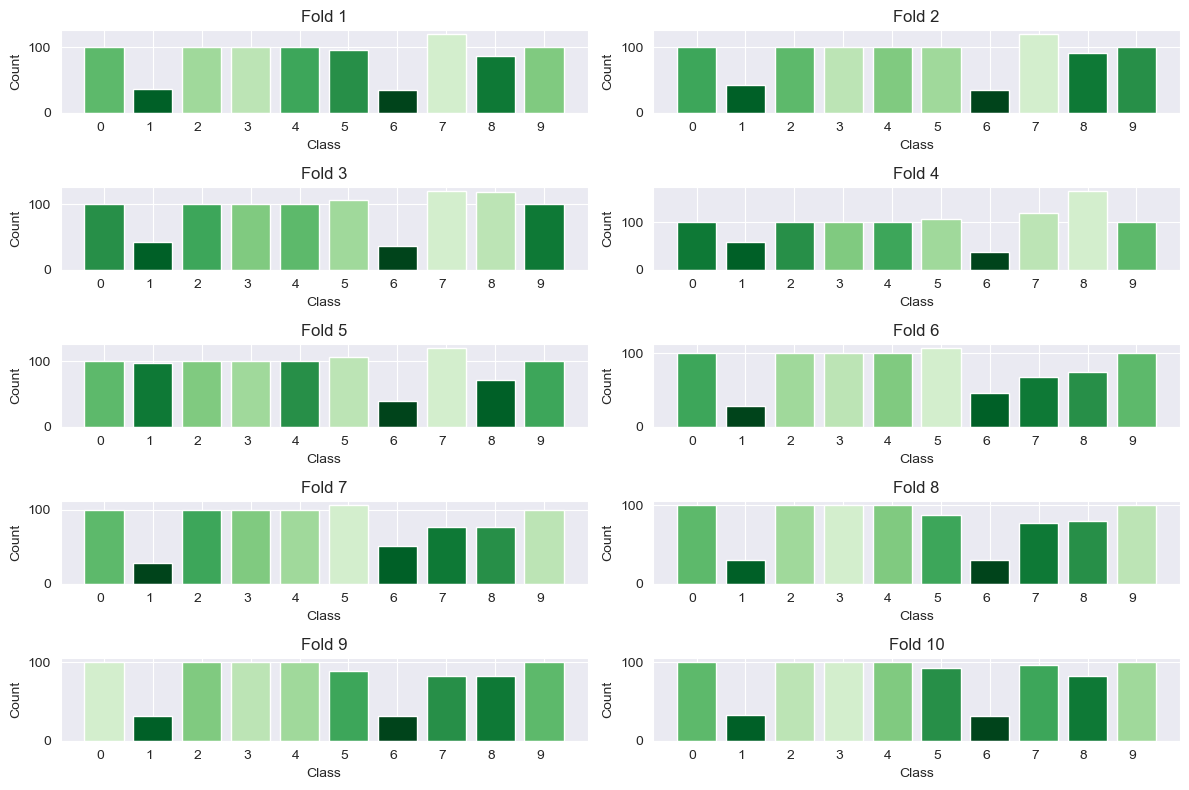

In [7]:
def plot_class_distribution(dataset):
    fold = 0
    rows = int(np.ceil(len(dataset) / 2))
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
    cmap = plt.get_cmap('Greens')

    for df, ax in zip(dataset, axs.flat):
        class_counts = df['Label'].value_counts()
        class_labels = class_counts.index
        class_values = class_counts.values
        colors = cmap(np.linspace(0.2, 1, len(class_labels)))
        ax.bar(class_labels, class_values, color=colors)
        ax.set(xlabel='Class', ylabel='Count', title=f'Fold {fold + 1}')
        ax.set_xticks(class_labels)
        ax.set_xticklabels(class_labels, rotation=0, ha='right')  # Set rotation to 0 for vertical orientation

        fold += 1

    plt.tight_layout()
    plt.show()


plot_class_distribution(datasets)

Because we noticed that the classes are unbalanced, for each model when preparing the data we did oversampling with SMOTE.

## Classification

### Plot the learning curves for accuracy and loss and the confusion matrix of the predictions vs the true labels

In [8]:
def plot_graphs(history, y_true, y_pred, class_labels):
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')

    # Adjust layout
    plt.tight_layout()
    plt.show()

### Prepare the datasets for training and testing

In [9]:
def prepare_datasets(fold):
    test_data = datasets[fold]
    test_labels = test_data['Label'].values
    test_data = test_data.drop(columns=['Label']).values

    train_datasets = datasets[:fold] + datasets[fold + 1:]
    train_data = pd.concat(train_datasets)

    smote = SMOTE(sampling_strategy='auto', random_state=42)

    train_data, train_labels = smote.fit_resample(train_data, train_data['Label'])
    train_data = train_data.drop(columns=['Label']).values

    return train_data, train_labels, test_data, test_labels

### Define the architecture of the MLP model

In [10]:
def build_MLP(input_neurons, hidden_neurons, output_neurons, learning_rate, regulizer, dropout):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=input_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=regulizer, l2=regulizer)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=hidden_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=hidden_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=output_neurons, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

### Define the training strategies of the MLP model

In [11]:
def train_MLP(mlp_model, train_data, train_labels, test_data, test_labels, patience, batch_size, num_epochs):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    history = mlp_model.fit(train_data, train_labels,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks = [early_stopping],
                        validation_data = (test_data,test_labels),
                        verbose=0)
    
    return history

Define the architecture of the CNN model

In [12]:
def build_CNN(input_shape, num_classes, learning_rate, dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

### Define the training strategies of the CNN model

In [13]:
def train_CNN(cnn_model, train_data, train_labels, test_data, test_labels, patience, batch_size, num_epochs):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    history = cnn_model.fit(train_data, train_labels,
                            epochs=num_epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            validation_data=(test_data, test_labels),
                            verbose=0)

    return history

# MLP

### Performance evaluation of the MLP and defined parameters of the model

Fold 1
28/28 [==============================] - 0s 895us/step


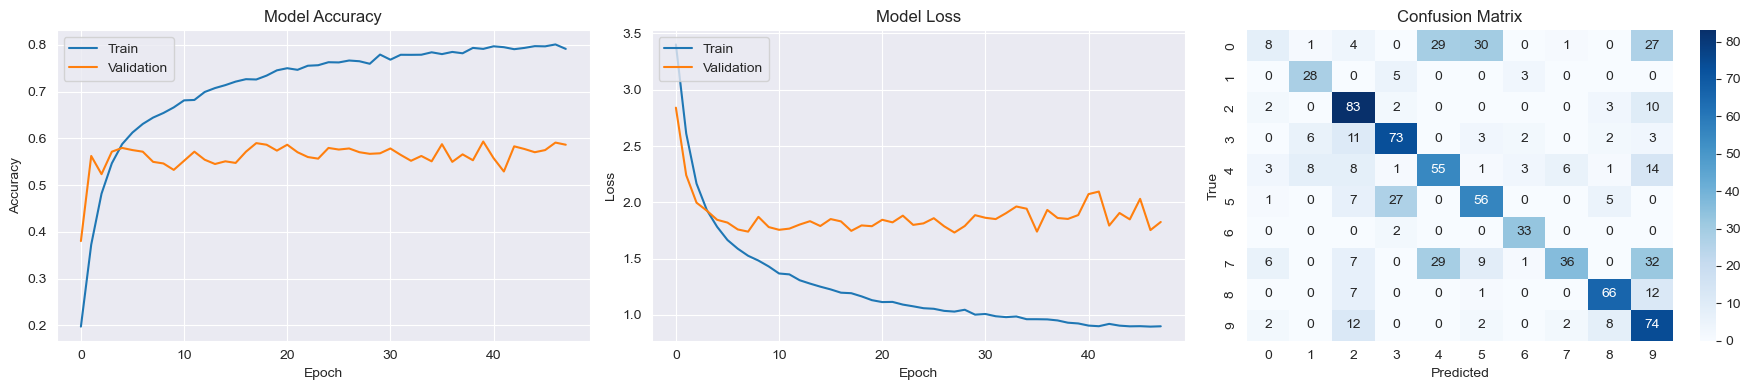

Fold 2
28/28 [==============================] - 0s 874us/step


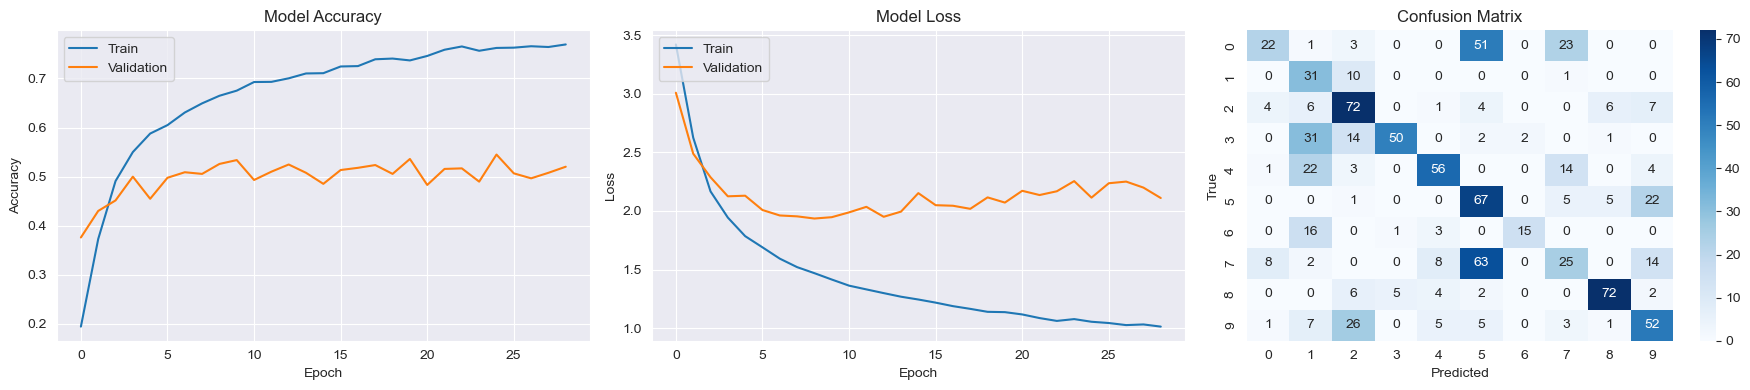

Fold 3
29/29 [==============================] - 0s 1ms/step


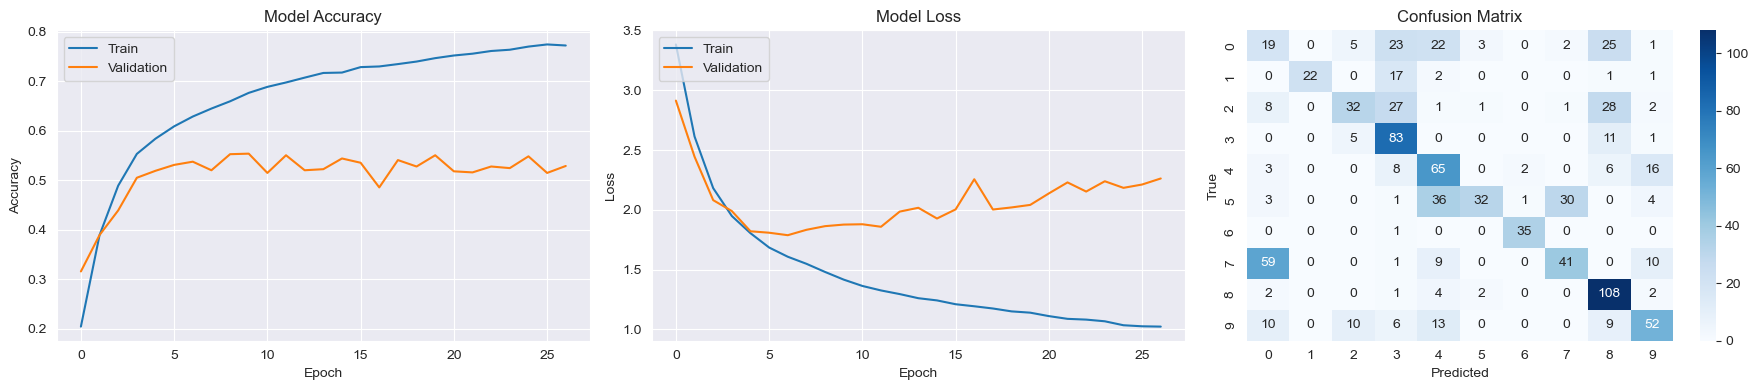

Fold 4
31/31 [==============================] - 0s 1ms/step


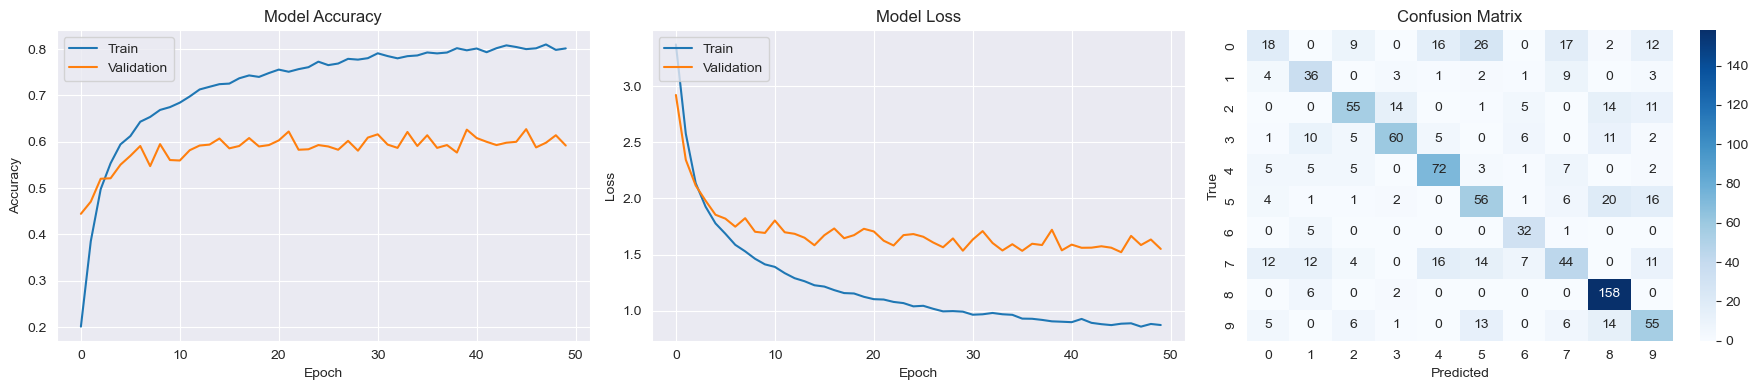

Fold 5
30/30 [==============================] - 0s 712us/step


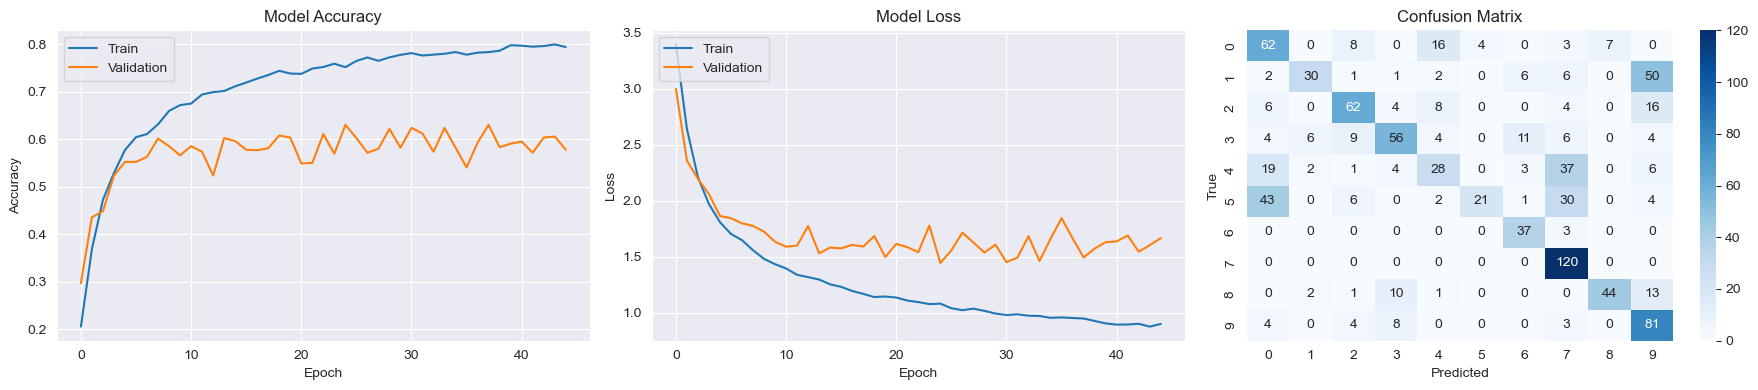

Fold 6
26/26 [==============================] - 0s 884us/step


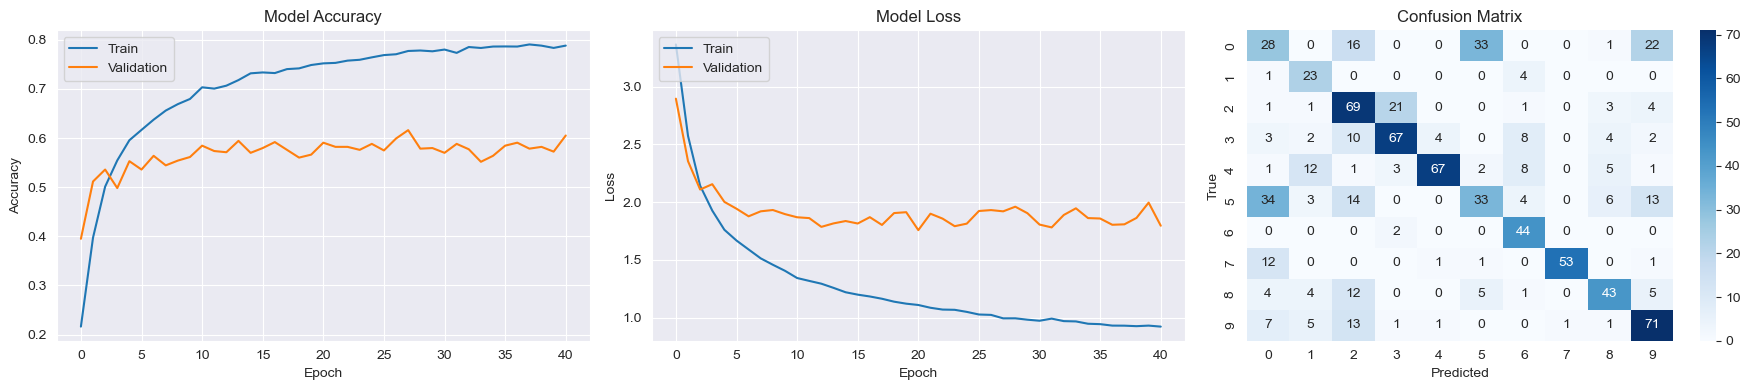

Fold 7
27/27 [==============================] - 0s 750us/step


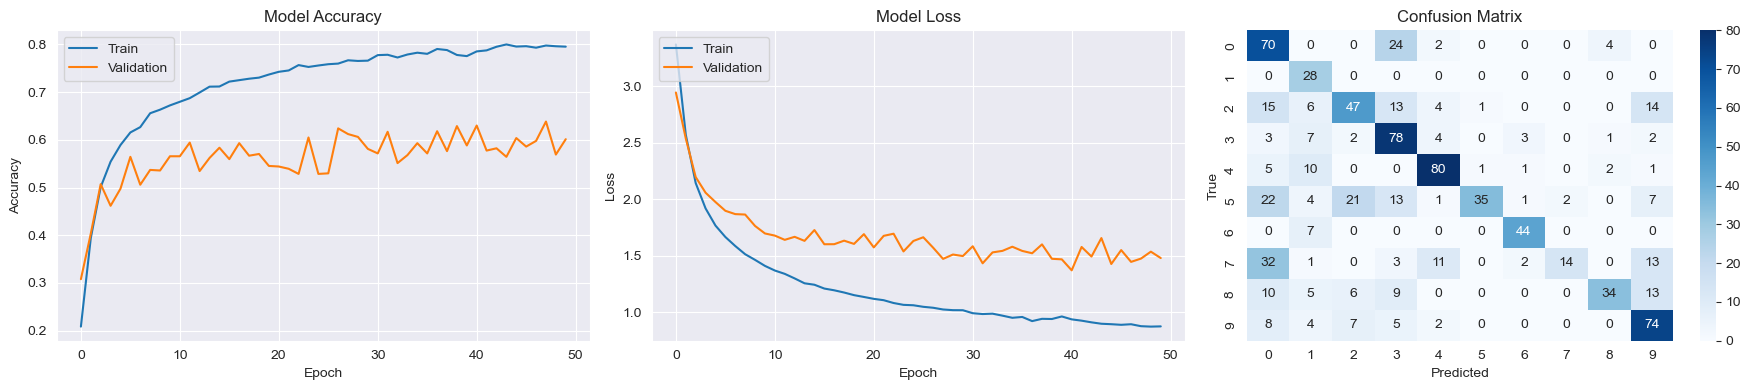

Fold 8
26/26 [==============================] - 0s 786us/step


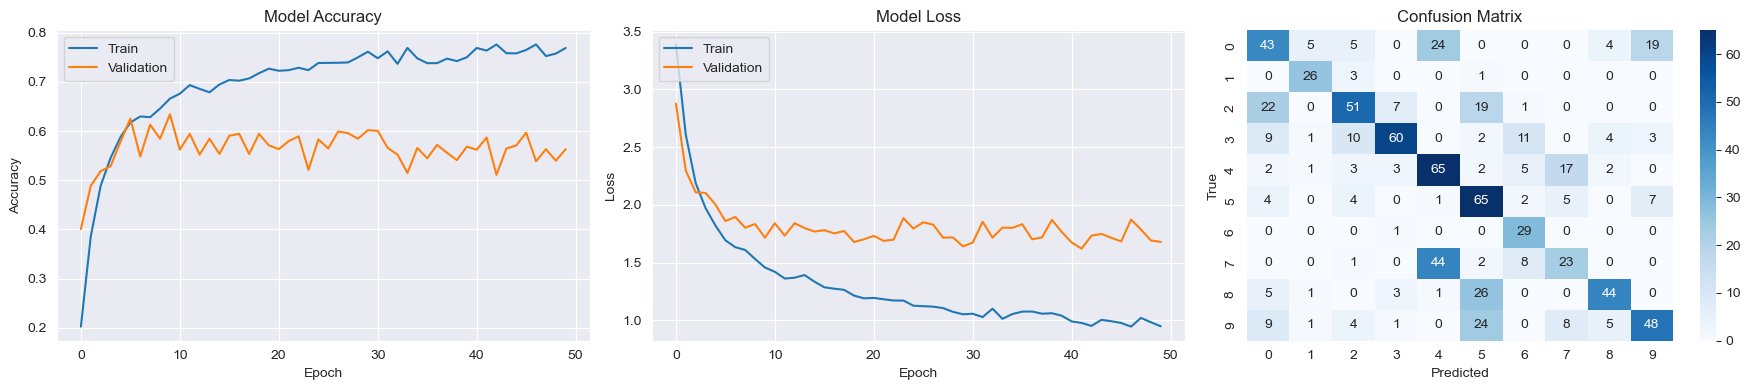

Fold 9
26/26 [==============================] - 0s 848us/step


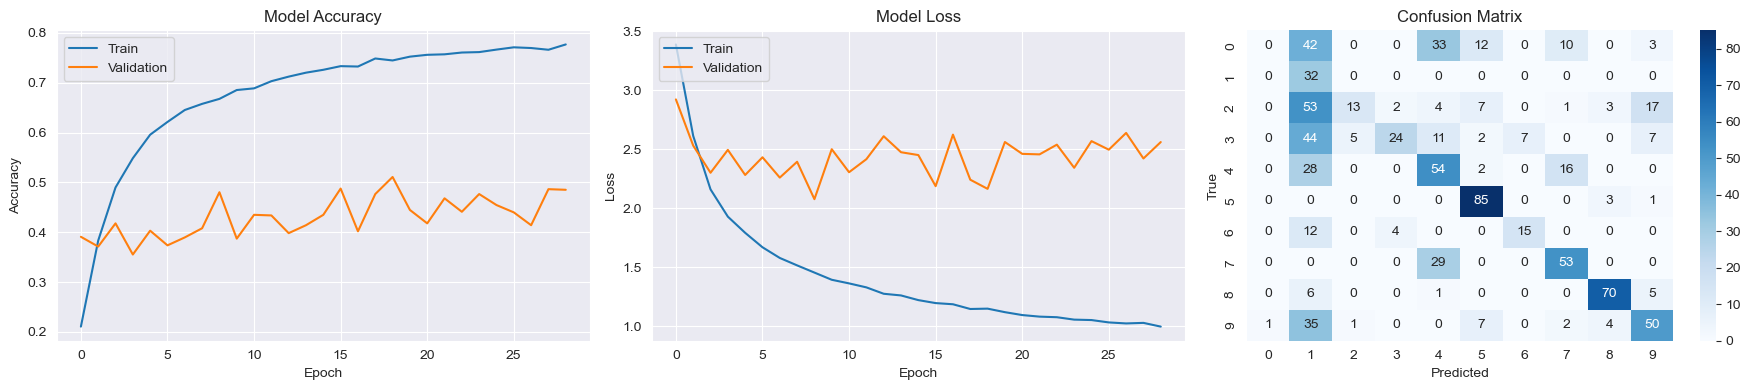

Fold 10
27/27 [==============================] - 0s 824us/step


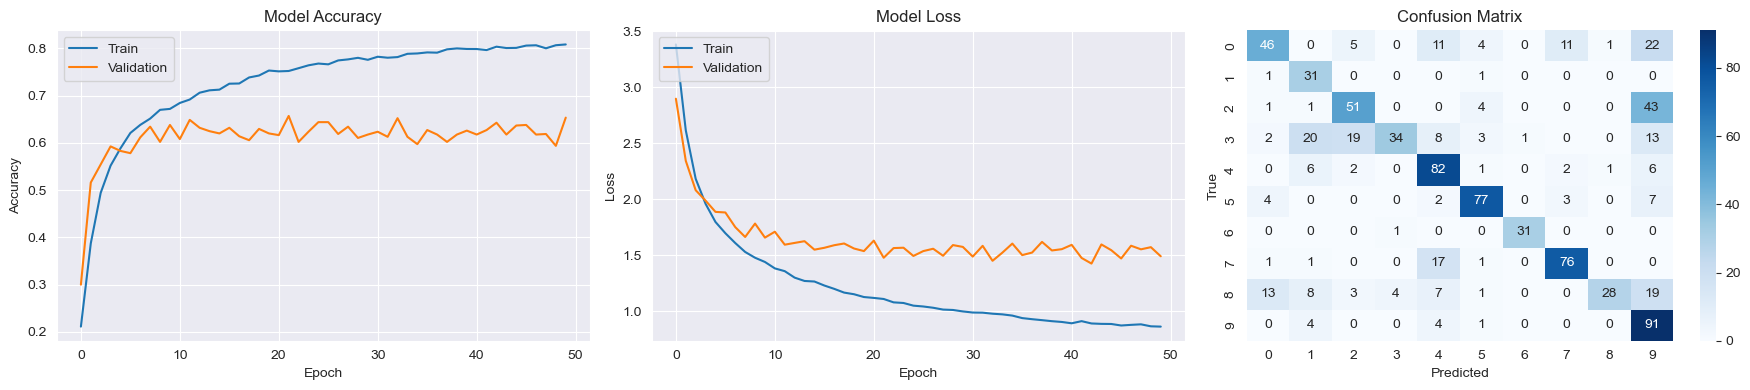


Average Accuracy for MLP: 0.5714
Standard Deviation for MLP Accuracy: 0.0463


In [14]:
cv_scores_mlp = []

for fold in range(10):
    print(f"Fold {fold + 1}")
    train_data, train_labels, test_data, test_labels = prepare_datasets(fold)

    mlp_model = build_MLP(input_neurons=512,
                      hidden_neurons=512,
                      output_neurons=10,
                      learning_rate=0.0005,
                      regulizer=0.001,
                      dropout=0.5)

    history = train_MLP(mlp_model, train_data, train_labels, test_data, test_labels,
                        patience=20,
                        batch_size=128,
                        num_epochs=50)

    predictions = mlp_model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plot_graphs(history, test_labels, predicted_labels, class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    
    accuracy = accuracy_score(test_labels, predicted_labels)
    cv_scores_mlp.append(accuracy)

overall_average_accuracy_mlp = np.mean(cv_scores_mlp)
print(f"\nAverage Accuracy for MLP: {overall_average_accuracy_mlp:.4f}")
mlp_std = np.std(cv_scores_mlp)
print(f"Standard Deviation for MLP Accuracy: {mlp_std:.4f}")


# CNN

### Performance evaluation of the CNN and defined parameters of the model

Fold 1
28/28 [==============================] - 0s 1ms/step


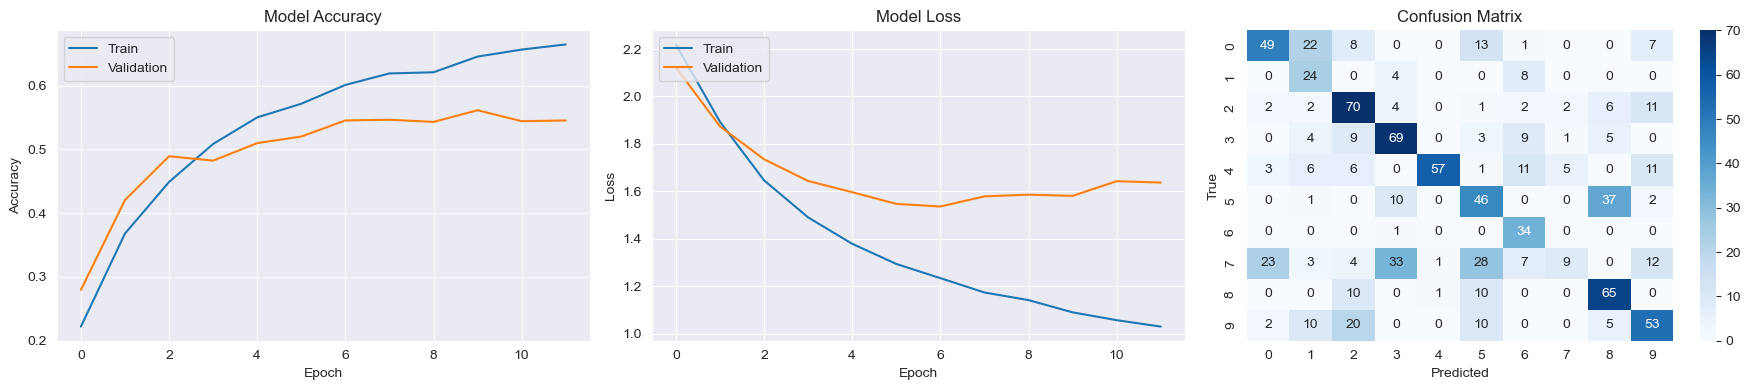

Fold 2
28/28 [==============================] - 0s 1ms/step


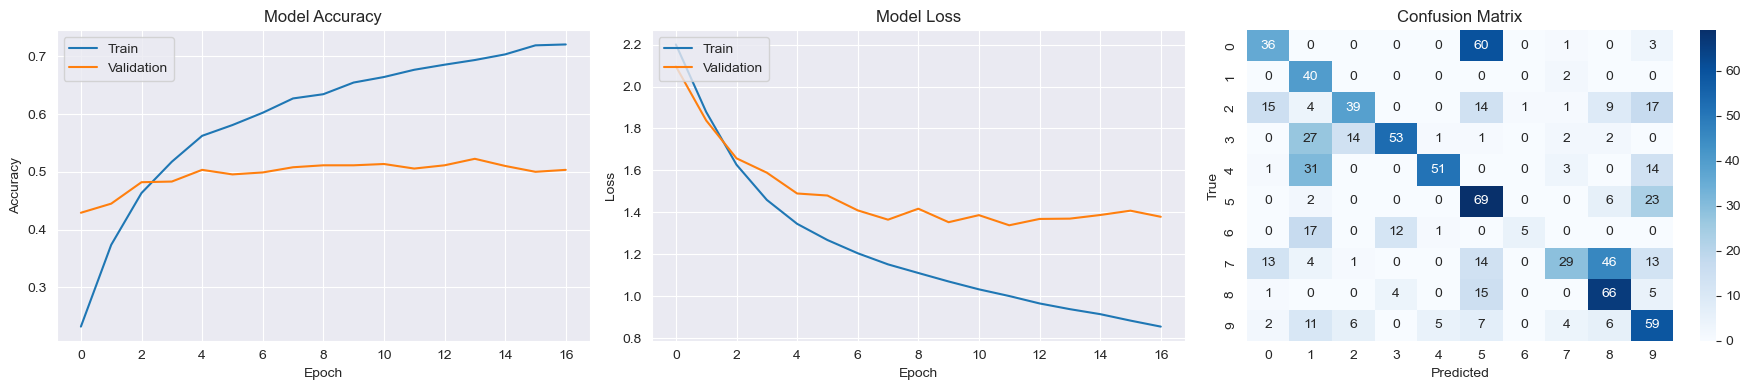

Fold 3
29/29 [==============================] - 0s 1ms/step


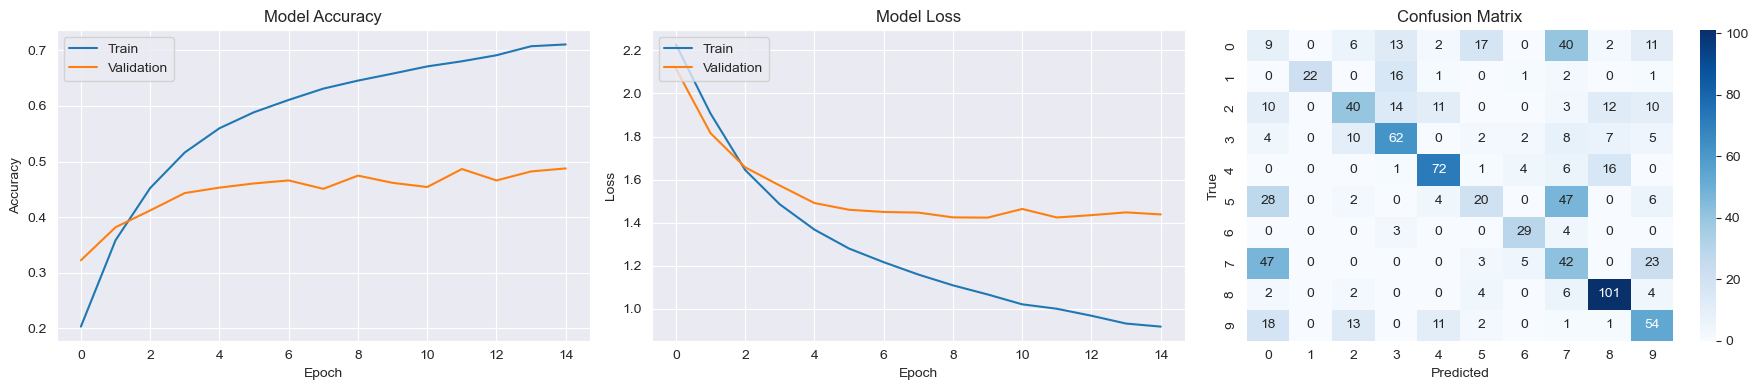

Fold 4
31/31 [==============================] - 0s 1ms/step


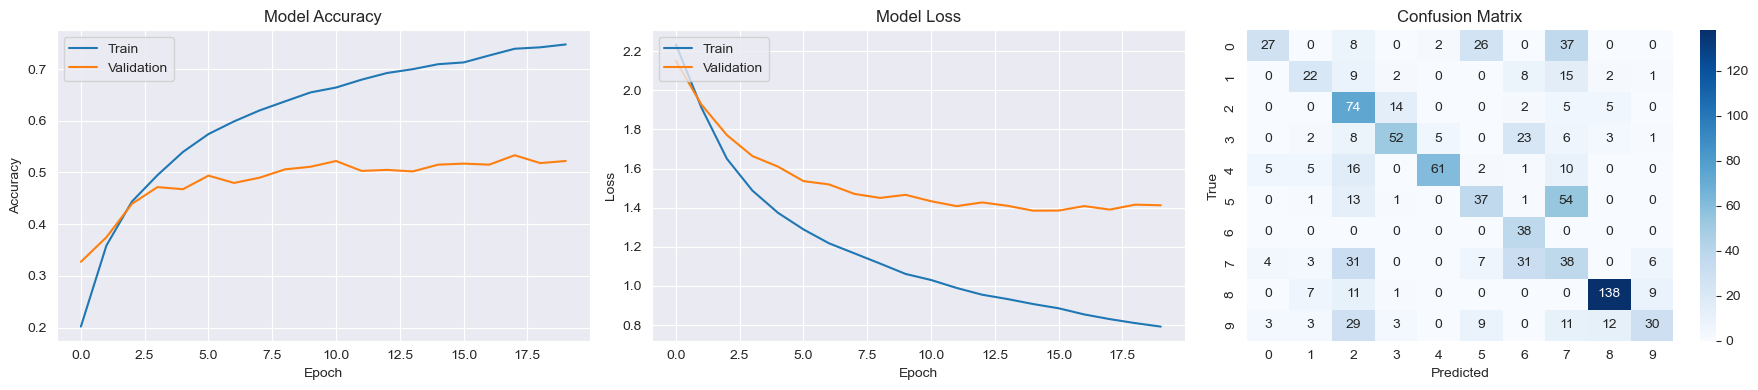

Fold 5
30/30 [==============================] - 0s 1ms/step


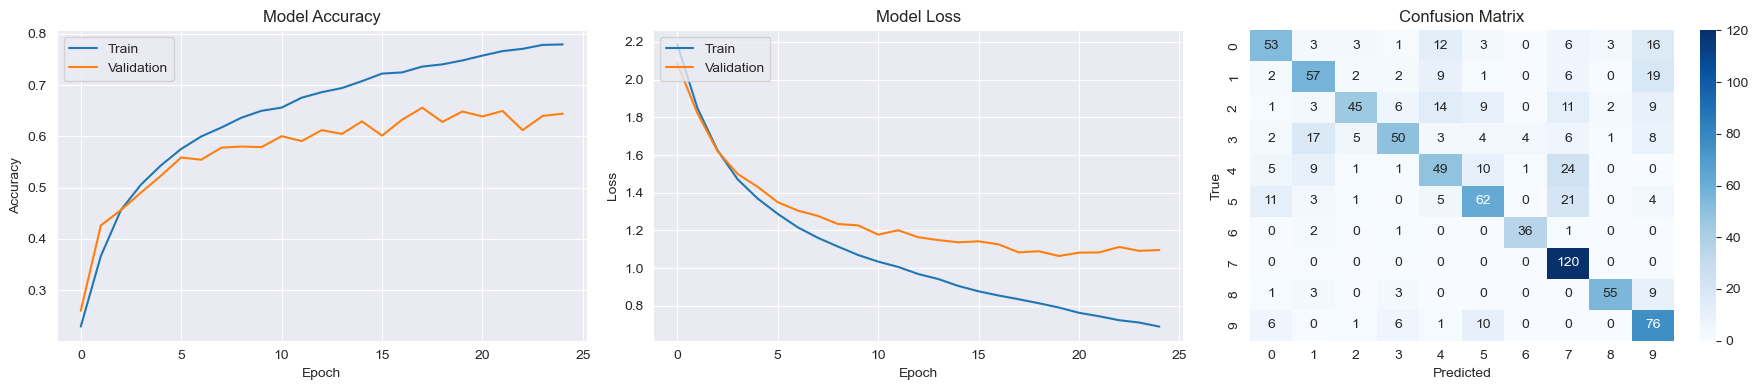

Fold 6
26/26 [==============================] - 0s 1ms/step


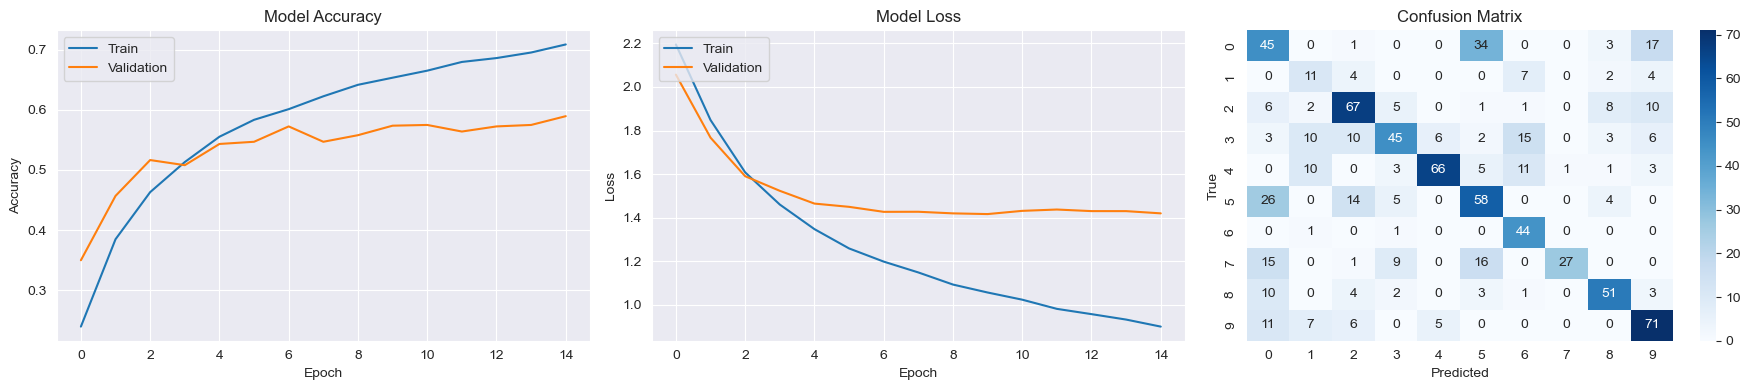

Fold 7
27/27 [==============================] - 0s 1ms/step


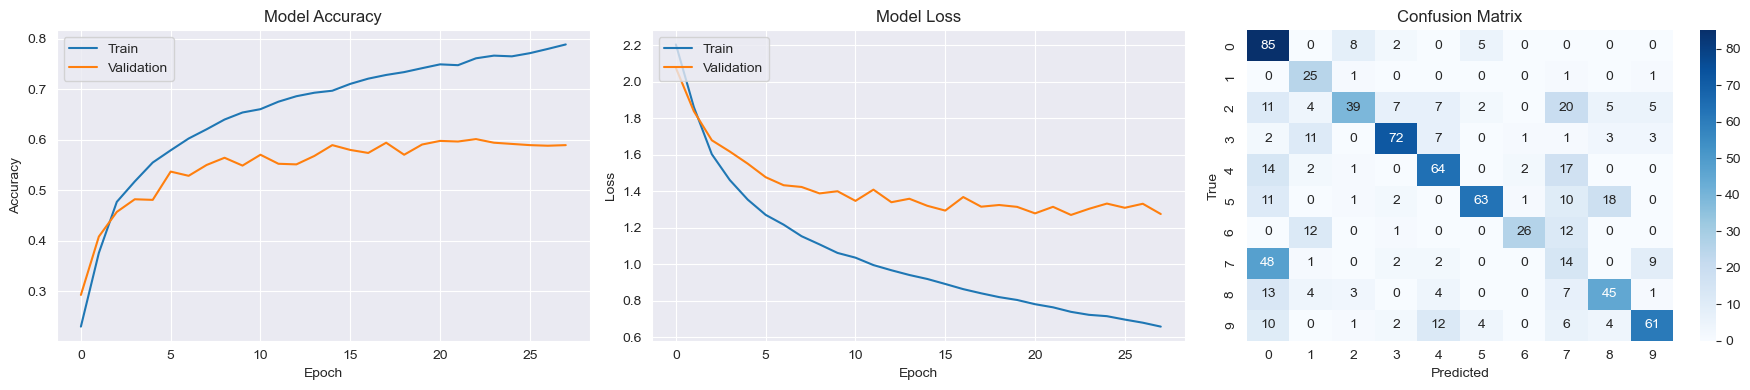

Fold 8
26/26 [==============================] - 0s 1ms/step


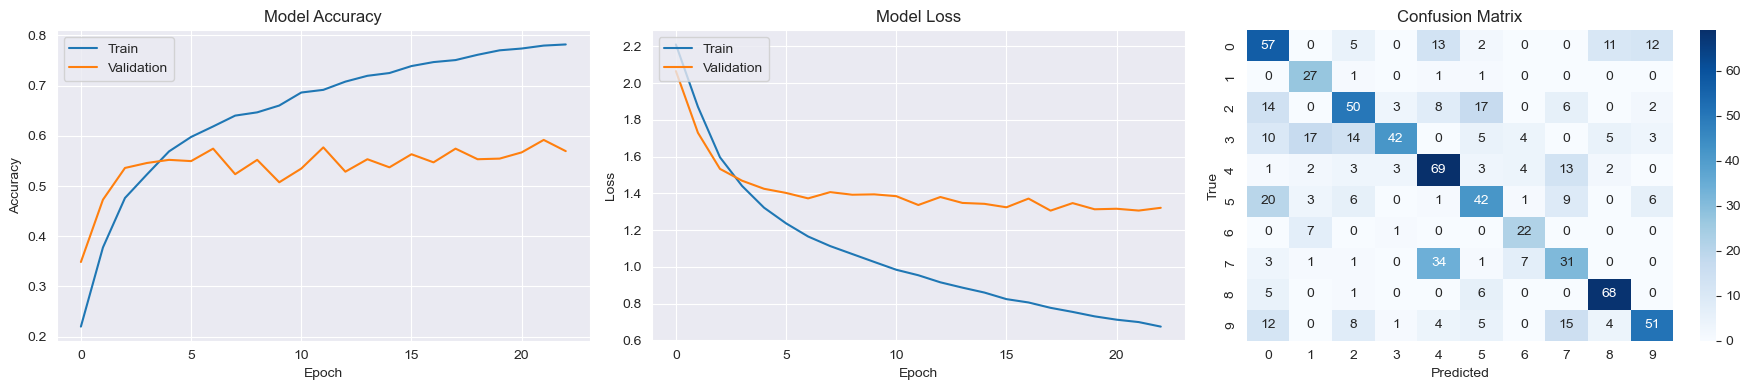

Fold 9
26/26 [==============================] - 0s 1ms/step


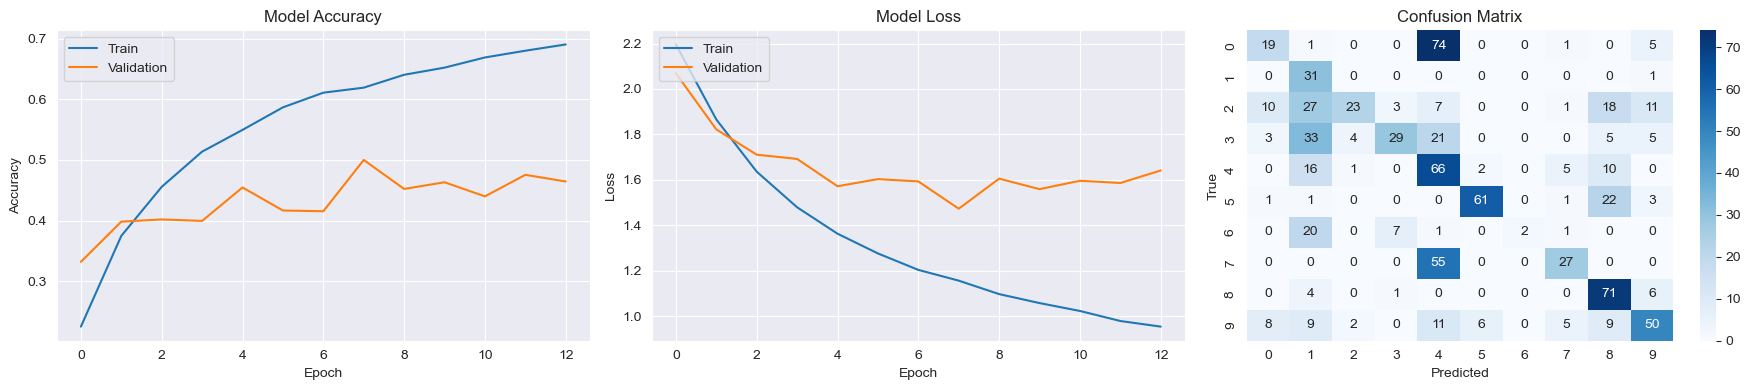

Fold 10
27/27 [==============================] - 0s 1ms/step


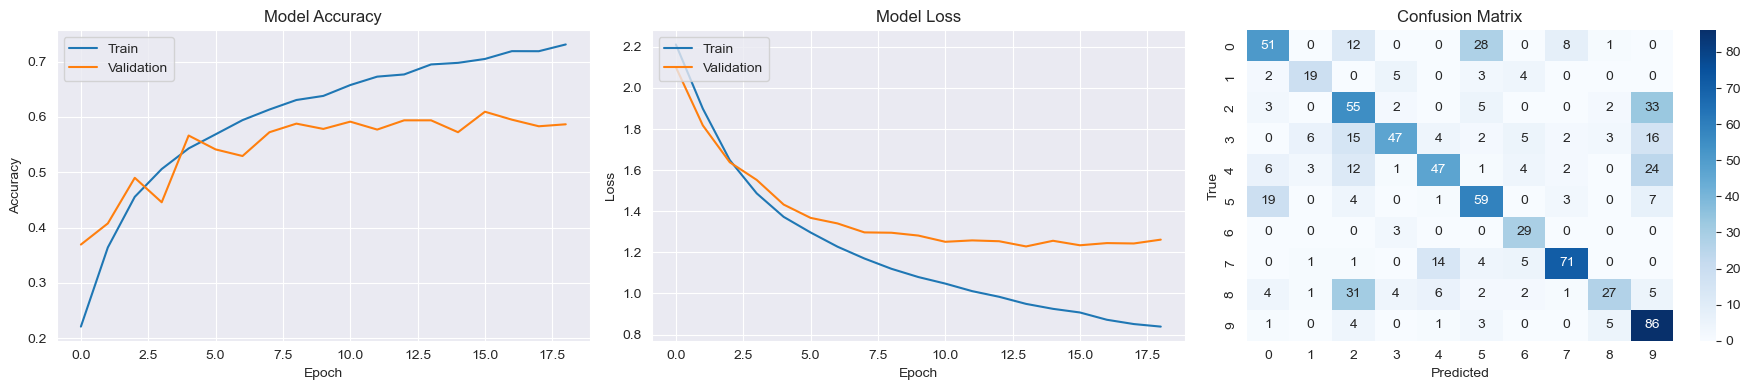


Accuracy for CNN: 0.5502
Standard Deviation for CNN Accuracy: 0.0528


In [15]:
cv_scores_cnn = []
for fold in range(10):
    print(f"Fold {fold + 1}")
    train_data, train_labels, test_data, test_labels = prepare_datasets(fold)

    cnn_model = build_CNN(input_shape=train_data.shape[1:],
                          num_classes=10,
                          learning_rate=0.0001,
                          dropout_rate=0.5)

    history = train_CNN(cnn_model, train_data, train_labels, test_data, test_labels,
                        patience=5,
                        batch_size=32,
                        num_epochs=50)

    predictions_cnn = cnn_model.predict(test_data)
    predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)
    
    plot_graphs(history, test_labels, predicted_labels_cnn, class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    
    accuracy = accuracy_score(test_labels, predicted_labels_cnn)
    cv_scores_cnn.append(accuracy)

overall_average_accuracy_cnn = np.mean(cv_scores_cnn)
print(f"\nAccuracy for CNN: {overall_average_accuracy_cnn:.4f}")
cnn_std = np.std(cv_scores_cnn)
print(f"Standard Deviation for CNN Accuracy: {cnn_std:.4f}")
